In [2]:
# Install necessary libraries
!apt-get install tesseract-ocr
!pip install pytesseract
!pip install opencv-python
!pip install matplotlib
!pip install scikit-image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (7,892 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120882 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

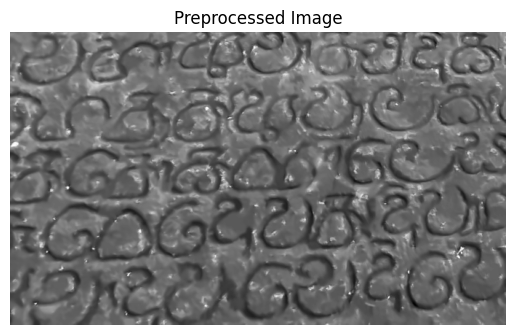

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx=0.5, fy=0.5)
    img = cv2.convertScaleAbs(img)
    img = cv2.fastNlMeansDenoising(img, None, h=10)
    img = img.astype(np.float32) / 255.0
    img = cv2.convertScaleAbs(img * 255.0)
    return img

image_path = "IMG_5694.jpg"
preprocessed_img = preprocess_image(image_path)


plt.imshow(preprocessed_img, cmap='gray')
plt.axis('off')
plt.title('Preprocessed Image')
plt.show()


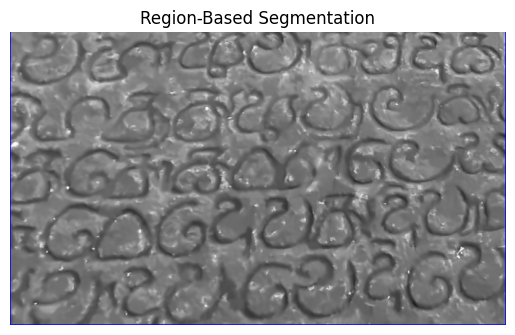

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for region-based segmentation using watershed algorithm
def region_based_segmentation(img):
    # Threshold the image to obtain a binary image
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Perform morphological operations to clean up the image
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Perform a distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

    # Normalize the distance transform to range 0-255
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Convert sure_fg to uint8 type
    sure_fg = np.uint8(sure_fg)

    # Find unknown region
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    sure_bg = 255 - sure_bg

    # Mark the unknown region in sure_bg
    sure_fg = cv2.subtract(sure_fg, sure_bg)

    # Label the markers for watershed algorithm
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[sure_bg == 255] = 0

    # Apply watershed algorithm
    img_copy = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.watershed(img_copy, markers)

    # Highlight the segmented regions on the original image
    img_copy[markers == -1] = [0, 0, 255]  # Mark watershed boundaries in red

    return img_copy

# Apply region-based segmentation to the preprocessed image
segmented_img_region = region_based_segmentation(preprocessed_img)

# Display the result of region-based segmentation
plt.imshow(segmented_img_region)
plt.axis('off')
plt.title('Region-Based Segmentation')
plt.show()


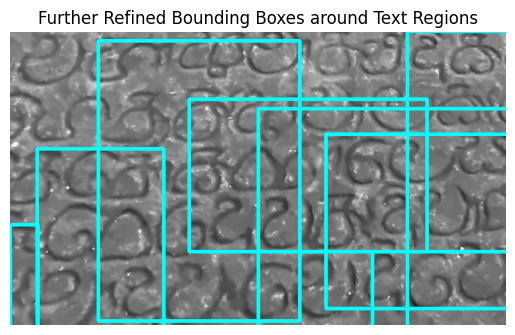

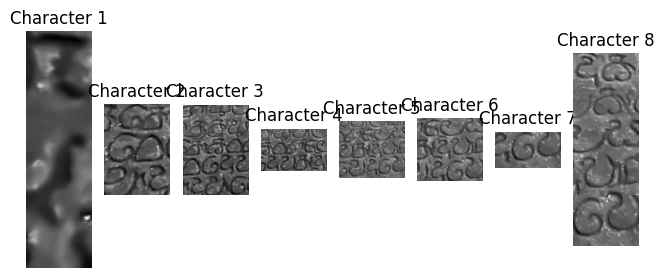

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Further enhanced function for character extraction with refined contours
def extract_characters_further_enhanced_segmented(segmented_img, threshold_percentage=62):
    # Invert the image
    inverted_img = cv2.bitwise_not(segmented_img)

    # Increase dilation and add a bit of erosion to make contours more prominent
    dilated_edges = cv2.dilate(inverted_img, None, iterations=3)
    eroded_edges = cv2.erode(dilated_edges, None, iterations=3)

    # Compute a dynamic threshold based on the specified percentage
    threshold_value = np.percentile(eroded_edges, threshold_percentage)

    # Apply binary thresholding to focus on dark lines
    _, binary_thresh = cv2.threshold(eroded_edges, threshold_value, 255, cv2.THRESH_BINARY)

    # Further morphological operations for cleaning up the image
    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(binary_thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_OPEN, kernel, iterations=3)

    # Find contours on the cleaned image
    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Adjust contour area thresholds based on the characteristics of region-based segmentation
    min_contour_area = 500  # Adjusted minimum contour area
    max_contour_area = 5000  # Adjusted maximum contour area

    # Filter contours based on area
    filtered_contours = [cnt for cnt in contours if min_contour_area < cv2.contourArea(cnt) < max_contour_area]

    result_img = cv2.cvtColor(segmented_img, cv2.COLOR_GRAY2BGR)

    bounding_boxes = [cv2.boundingRect(cnt) for cnt in filtered_contours]

    # Sort bounding boxes based on their x-coordinate
    bounding_boxes.sort(key=lambda x: x[0])

    # Process bounding boxes to avoid overlap and ensure each box contains only one character
    processed_boxes = []

    for x, y, w, h in bounding_boxes:
        # Check if the width is larger than a threshold, suggesting the possibility of multiple characters
        if w > 1.5 * h:
            # Split the box into multiple smaller ones, each containing one character
            num_chars = max(int(w / h), 1)
            char_width = w // num_chars
            for i in range(num_chars):
                processed_boxes.append((x + i * char_width, y, char_width, h))
        else:
            processed_boxes.append((x, y, w, h))

    # Use clustering to merge horizontally close bounding boxes
    processed_boxes = cluster_bounding_boxes(processed_boxes, max_horizontal_distance=30)

    # Keep track of characters already included in a box
    seen_characters = set()

    for x, y, w, h in processed_boxes:
        char_img = segmented_img[y:y+h, x:x+w]
        # Convert character image to a hash for efficient comparison
        char_hash = hash(char_img.tobytes())

        if char_hash not in seen_characters:
            seen_characters.add(char_hash)

            cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 255), 3)

    plt.imshow(result_img)
    plt.axis('off')
    plt.title('Further Refined Bounding Boxes around Text Regions')
    plt.show()

    characters = [segmented_img[y:y+h, x:x+w] for x, y, w, h in processed_boxes]

    # Enhance the visibility of characters using contrast stretching
    contrast_stretched_characters = [cv2.normalize(char, None, 0, 255, cv2.NORM_MINMAX) for char in characters]

    plt.figure(figsize=(20, 5))
    for i in range(min(20, len(contrast_stretched_characters))):
        plt.subplot(1, 20, i + 1)
        plt.imshow(contrast_stretched_characters[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Character {i + 1}')
    plt.show()

def cluster_bounding_boxes(boxes, max_horizontal_distance):
    # Cluster bounding boxes based on horizontal distance
    clusters = []
    current_cluster = [boxes[0]]

    for box1 in boxes[1:]:
        x1, _, w1, _ = box1
        x2, _, _, _ = current_cluster[-1]

        if x1 - x2 < max_horizontal_distance:
            current_cluster.append(box1)
        else:
            clusters.append(current_cluster)
            current_cluster = [box1]

    clusters.append(current_cluster)

    # Merge each cluster into a single bounding box
    merged_boxes = [(min(c, key=lambda x: x[0])[0], min(c, key=lambda x: x[1])[1],
                     max(c, key=lambda x: x[0])[0] + max(c, key=lambda x: x[2])[2],
                     max(c, key=lambda x: x[1])[1] + max(c, key=lambda x: x[3])[3]) for c in clusters]

    return merged_boxes

# Assuming 'preprocessed_img' is already defined and loaded
# Extract characters with further enhanced contours and refined bounding boxes
extract_characters_further_enhanced_segmented(preprocessed_img, threshold_percentage=64)


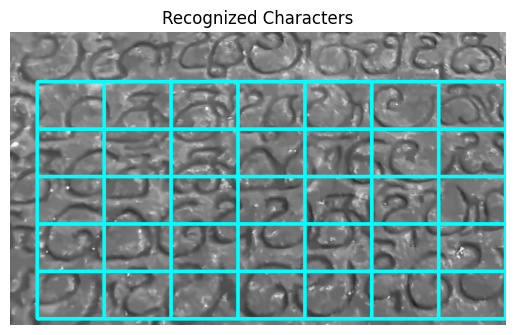

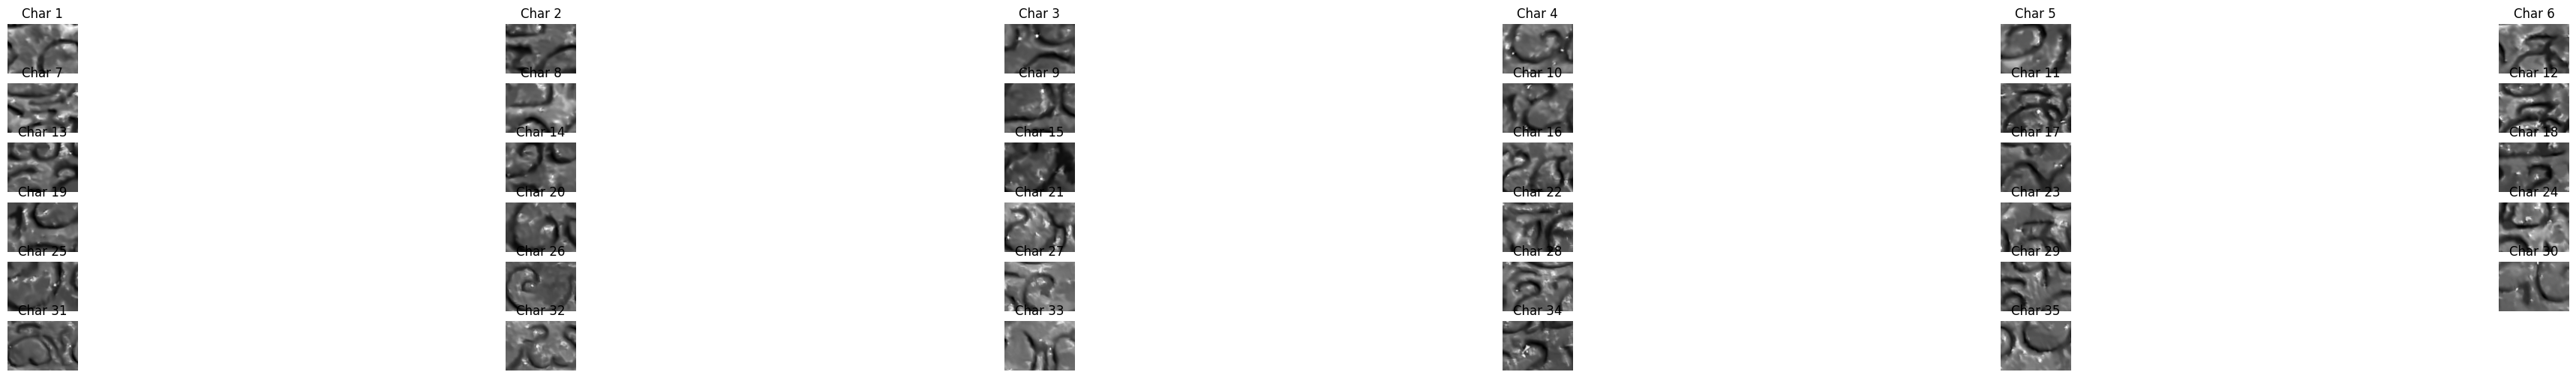

In [81]:
def extract_characters_dynamic_grid(segmented_img, threshold_percentage=63):
    inverted_img = cv2.bitwise_not(segmented_img)

    dilated_edges = cv2.dilate(inverted_img, None, iterations=3)
    eroded_edges = cv2.erode(dilated_edges, None, iterations=3)

    threshold_value = np.percentile(eroded_edges, threshold_percentage)
    _, binary_thresh = cv2.threshold(eroded_edges, threshold_value, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(binary_thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_OPEN, kernel, iterations=3)

    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_contour_area = 720
    max_contour_area = 10000

    filtered_contours = [cnt for cnt in contours if min_contour_area < cv2.contourArea(cnt) < max_contour_area]

    result_img = cv2.cvtColor(segmented_img, cv2.COLOR_GRAY2BGR)

    bounding_boxes = [cv2.boundingRect(cnt) for cnt in filtered_contours]

    bounding_boxes.sort(key=lambda x: x[0])

    # Process bounding boxes to avoid overlap and contain only one character per box
    processed_boxes = []

    for x, y, w, h in bounding_boxes:
        # Check if the box is close to an existing box, if yes, create a bigger bounding box
        overlap = False
        for i, (x_p, y_p, w_p, h_p) in enumerate(processed_boxes):
            if (
                (x_p <= x <= x_p + w_p) or
                (x <= x_p <= x + w) or
                (y_p <= y <= y_p + h_p) or
                (y <= y_p <= y + h)
            ):
                overlap = True
                processed_boxes[i] = (
                    min(x, x_p),
                    min(y, y_p),
                    max(x + w, x_p + w_p) - min(x, x_p),
                    max(y + h, y_p + h_p) - min(y, y_p)
                )
                break

        if not overlap:
            processed_boxes.append((x, y, w, h))

    # Calculate the dynamic grid size based on the maximum width and height of bounding boxes
    max_width = max(box[2] for box in processed_boxes)
    max_height = max(box[3] for box in processed_boxes)
    grid_rows = 5  # You can adjust this as needed
    grid_cols = 7  # You can adjust this as needed

    # Divide the large box into a dynamic grid and bring it a bit higher
    divided_boxes = []
    for x, y, w, h in processed_boxes:
        char_width = w // grid_cols
        char_height = h // grid_rows
        for i in range(grid_cols):
            for j in range(grid_rows):
                # Bring the box a bit higher by subtracting a small value from the y coordinate
                divided_boxes.append((x + i * char_width, y + j * char_height - 5, char_width, char_height))

    for x, y, w, h in divided_boxes:
        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 255), 3)

    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f'Recognized Characters')
    plt.show()

    characters = [segmented_img[y:y+h, x:x+w] for x, y, w, h in divided_boxes]

    # Enhance the visibility of characters using contrast stretching
    contrast_stretched_characters = [cv2.normalize(char, None, 0, 255, cv2.NORM_MINMAX) for char in characters]

    plt.figure(figsize=(50, 6))
    for i in range(min(50, len(contrast_stretched_characters))):
        plt.subplot(6, 6, i + 1)
        plt.imshow(contrast_stretched_characters[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Char {i + 1}')
    plt.show()


extract_characters_dynamic_grid(preprocessed_img, threshold_percentage=68)


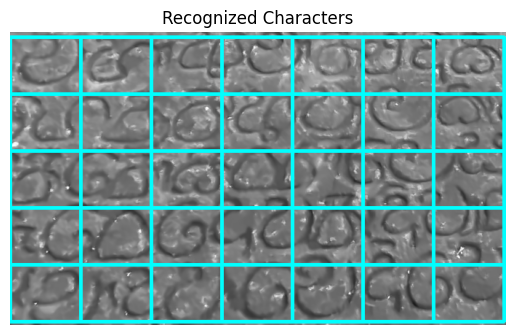

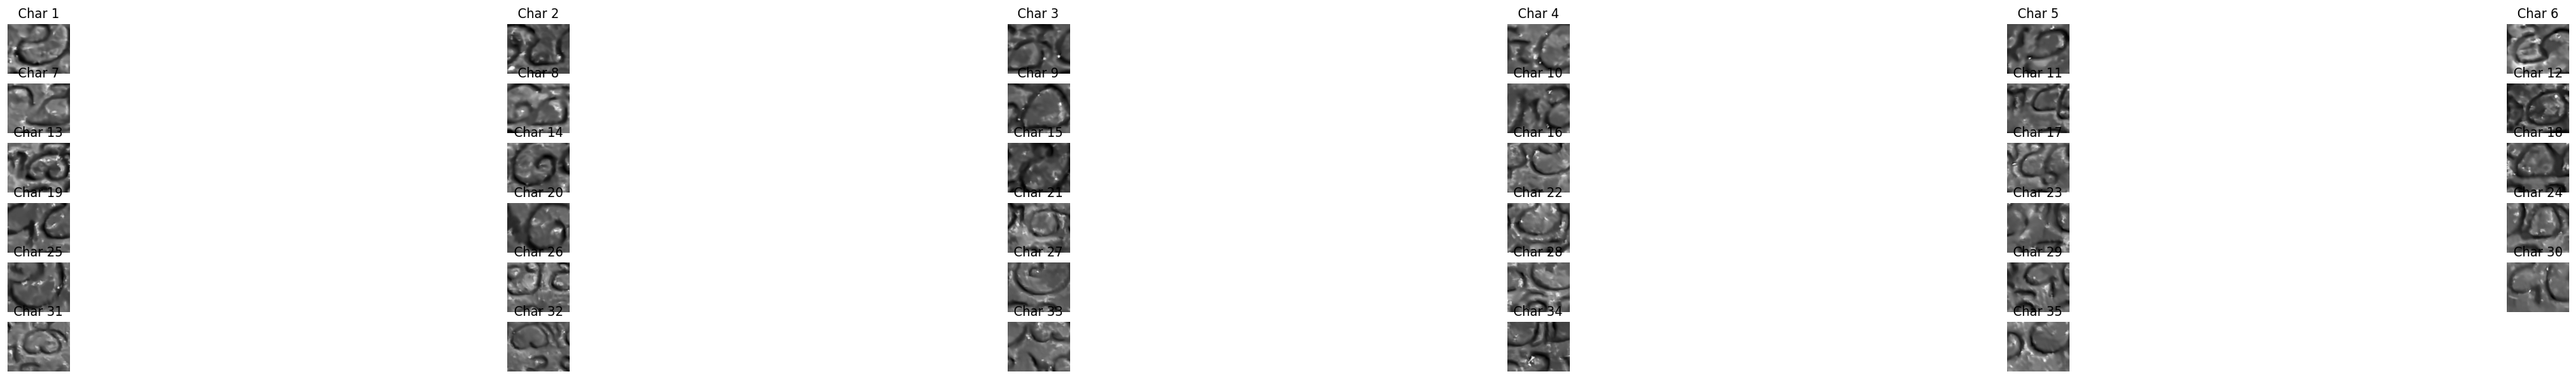

In [76]:
def extract_characters_dynamic_grid(segmented_img, threshold_percentage=63):
    inverted_img = cv2.bitwise_not(segmented_img)

    dilated_edges = cv2.dilate(inverted_img, None, iterations=3)
    eroded_edges = cv2.erode(dilated_edges, None, iterations=3)

    threshold_value = np.percentile(eroded_edges, threshold_percentage)
    _, binary_thresh = cv2.threshold(eroded_edges, threshold_value, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3, 3), np.uint8)
    cleaned_image = cv2.morphologyEx(binary_thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_OPEN, kernel, iterations=3)

    contours, _ = cv2.findContours(cleaned_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_contour_area = 720
    max_contour_area = 10000

    filtered_contours = [cnt for cnt in contours if min_contour_area < cv2.contourArea(cnt) < max_contour_area]

    result_img = cv2.cvtColor(segmented_img, cv2.COLOR_GRAY2BGR)

    bounding_boxes = [cv2.boundingRect(cnt) for cnt in filtered_contours]

    bounding_boxes.sort(key=lambda x: x[0])

    # Process bounding boxes to avoid overlap and contain only one character per box
    processed_boxes = []

    for x, y, w, h in bounding_boxes:
        # Check if the box is close to an existing box, if yes, create a bigger bounding box
        overlap = False
        for i, (x_p, y_p, w_p, h_p) in enumerate(processed_boxes):
            if (
                (x_p <= x <= x_p + w_p) or
                (x <= x_p <= x + w) or
                (y_p <= y <= y_p + h_p) or
                (y <= y_p <= y + h)
            ):
                overlap = True
                processed_boxes[i] = (
                    min(x, x_p),
                    min(y, y_p),
                    max(x + w, x_p + w_p) - min(x, x_p),
                    max(y + h, y_p + h_p) - min(y, y_p)
                )
                break

        if not overlap:
            processed_boxes.append((x, y, w, h))

    # Calculate the dynamic grid size based on the maximum width and height of bounding boxes
    max_width = max(box[2] for box in processed_boxes)
    max_height = max(box[3] for box in processed_boxes)
    grid_rows = 5  # You can adjust this as needed
    grid_cols = 7  # You can adjust this as needed

    # Divide the large box into a dynamic grid and bring it a bit higher
    divided_boxes = []
    for x, y, w, h in processed_boxes:
        char_width = w // grid_cols
        char_height = h // grid_rows
        for i in range(grid_cols):
            for j in range(grid_rows):
                # Bring the box a bit higher by subtracting a small value from the y coordinate
                divided_boxes.append((x + i * char_width, y + j * char_height - 5, char_width, char_height))

    for x, y, w, h in divided_boxes:
        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 255), 3)

    plt.imshow(result_img)
    plt.axis('off')
    plt.title(f'Recognized Characters')
    plt.show()

    characters = [segmented_img[y:y+h, x:x+w] for x, y, w, h in divided_boxes]

    # Enhance the visibility of characters using contrast stretching
    contrast_stretched_characters = [cv2.normalize(char, None, 0, 255, cv2.NORM_MINMAX) for char in characters]

    plt.figure(figsize=(50, 6))
    for i in range(min(50, len(contrast_stretched_characters))):
        plt.subplot(6, 6, i + 1)
        plt.imshow(contrast_stretched_characters[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Char {i + 1}')
    plt.show()

    # Save the characters to a folder
    output_folder = 'output_characters'
    save_characters_to_folder(characters, output_folder)


def save_characters_to_folder(characters, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    # Save each character as a separate image
    for idx, character in enumerate(characters):
        if isinstance(character, (np.ndarray, np.generic)):
            # Convert to uint8 (if not already) and save as an image
            character = np.uint8(character)
            character_filename = os.path.join(output_folder, f'character_{idx + 1}.png')
            cv2.imwrite(character_filename, character)
        else:
            print(f"Skipping invalid data at index {idx}.")

extract_characters_dynamic_grid(preprocessed_img, threshold_percentage=63)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')